## Package Import

In [1]:
import os 
import numpy as np 
import pandas as pd 
from scipy.sparse import csr_matrix

import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.optim import SGD

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


import random
from matplotlib import pyplot as plt


/opt/conda/envs/recbole/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data Preprocess

In [8]:
dpath = 'archive-2'
data_list = []
for i in os.listdir(dpath):
    if 'combined_data' in i:
        data_list.append(i)
data_list

['combined_data_1.txt',
 'combined_data_3.txt',
 'combined_data_2.txt',
 'combined_data_4.txt']

In [9]:
df = pd.DataFrame({'Cust_ID','Rating','Timestamp'}) 

for data in data_list:
    temp_df = pd.read_csv(os.path.join(dpath, data), header = None, names = ['Cust_ID', 'Rating','Timestamp'], usecols = [0,1,2])
    temp_df['Rating'] = temp_df['Rating'].astype(float)
    df = pd.concat([df, temp_df])
    print("Loaded: ", data)

df.index = np.arange(0,len(df))

Loaded:  combined_data_1.txt
Loaded:  combined_data_3.txt
Loaded:  combined_data_2.txt
Loaded:  combined_data_4.txt


In [10]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()
df_nan

,index,Rating
0,0,True
1,1,True
2,2,True
3,3,True
4,551,True
...,...,...
17768,100488434,True
17769,100489040,True
17770,100489245,True
17771,100490608,True


In [12]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [4.0000e+00 4.0000e+00 4.0000e+00 ... 1.7773e+04 1.7773e+04 1.7773e+04]
Length: 100480507


In [13]:
df = df[pd.notnull(df['Rating'])]
df['Movie_Id'] = movie_np.astype(int)
df['Cust_ID'] = df['Cust_ID'].astype(int)
print(df.iloc[::5000000, :])

             0  Cust_ID  Rating   Timestamp  Movie_Id
4          NaN  1488844     3.0  2005-09-06         4
5000999    NaN   501954     2.0  2004-08-26       999
10001965   NaN   404654     5.0  2005-08-29      1965
15002879   NaN   886608     2.0  2005-09-19      2879
20003828   NaN  1193835     2.0  2003-08-13      3828
25004725   NaN    35179     4.0  2004-05-17      4725
30005671   NaN  2561536     3.0  2002-09-23      5671
35006571   NaN   200362     4.0  2005-02-28      6571
40007524   NaN   686629     4.0  2005-03-01      7524
45008342   NaN  1494017     2.0  2003-07-04      8342
50009229   NaN   437784     4.0  2005-07-30      9229
55010055   NaN   788058     4.0  2005-09-29     10055
60010827   NaN   433661     4.0  2002-01-18     10827
65011673   NaN  2402781     4.0  2004-11-10     11673
70012701   NaN   182620     4.0  2004-12-08     12701
75013585   NaN   506044     4.0  2004-09-28     13585
80014456   NaN   353605     2.0  2005-07-10     14456
85015119   NaN   664606     

In [15]:
df = df[['Cust_ID', 'Movie_Id', 'Rating','Timestamp']]

user2idx = {j:i for i,j in enumerate(df['Cust_ID'].unique())}
item2idx = {j:i for i,j in enumerate(df['Movie_Id'].unique())}
df['Cust_ID'] = df['Cust_ID'].map(user2idx)
df['Movie_Id'] = df['Movie_Id'].map(item2idx)
df

/tmp/ipykernel_21746/1478047817.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_ID'] = df['Cust_ID'].map(user2idx)
/tmp/ipykernel_21746/1478047817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = df['Movie_Id'].map(item2idx)


,Cust_ID,Movie_Id,Rating,Timestamp
4,0,0,3.0,2005-09-06
5,1,0,5.0,2005-05-13
6,2,0,4.0,2005-10-19
7,3,0,4.0,2005-12-26
8,4,0,3.0,2004-05-03
...,...,...,...,...
100498275,542,17769,4.0,2005-11-01
100498276,29273,17769,3.0,2005-07-19
100498277,29251,17769,1.0,2004-08-07
100498278,22793,17769,4.0,2004-05-28


In [16]:
df.to_csv('preprocessed_df_with_timestamp.csv', index=False)

## MF

In [2]:
df = pd.read_csv('preprocessed_df_with_timestamp.csv')

In [3]:
def predict(P, Q, mu, b_u, b_i, user, item):
    pred = mu + b_u[user] + b_i[item] + P[user, :].T.dot(Q[item, :])
    return pred

In [4]:
def sgd(P, Q, mu, b_u, b_i, samples, lr, reg):
    for user, item, rating in samples:
        pred = predict(P, Q, mu, b_u, b_i, user, item)
        
        error = rating - pred
        
        b_u[user] += lr * (error - reg * b_u[user])
        b_i[item] += lr * (error - reg * b_i[item])
        
        P[user, :] += lr * (error * Q[item, :] - reg * P[user, :])
        Q[item, :] += lr * (error * P[user, :] - reg * Q[item, :])

In [5]:
def rmse(samples, P, Q, mu, b_u, b_i):
    error = [] 
    for user,item,rating in samples:
        square_error = (rating - predict(P, Q, mu, b_u, b_i, user, item))**2
        error.append(square_error)
    rmse = np.sqrt(np.array(error).mean())
    return rmse

In [25]:
class MF_with_sgd(object):
    def __init__(self, df ,num_users, num_items, F, lr, reg, epochs):
        self.df = df
        self.num_users, self.num_items = num_users, num_items
        self.F = F
        self.lr = lr 
        self.reg = reg 
        self.epochs = epochs
        self.summary = pd.DataFrame(columns = ['epoch','rmse','val_rmse'])
        
    def build_samples(self): 
        self.samples = [] 
        self.users = self.df['Cust_ID'].values 
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        
        for idx in range(len(self.df)):
            if (idx % 10000000) == 0: 
                print(f"Loaded: {idx}th sample")
            self.samples.append((self.users[idx],self.items[idx],self.ratings[idx]))
    
    def train(self): 
        self.P = np.random.normal(scale = 1/self.F,size = (self.num_users, self.F))
        self.Q = np.random.normal(scale = 1/self.F,size = (self.num_items, self.F))
        
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        
        self.mu = self.df['Rating'].mean()
        
        np.random.shuffle(self.samples)
        
        self.train_samples = self.samples[:int(0.8*len(self.samples))]
        self.test_samples = self.samples[int(0.8*len(self.samples)):]
        for epoch in range(self.epochs): 
            print(f"Start: {epoch}th epoch")
            # np.random.shuffle(self.samples)
            sgd(self.P, self.Q, self.mu, self.b_u, self.b_i, self.train_samples, self.lr, self.reg)
            train_loss = rmse(self.train_samples, self.P, self.Q, self.mu, self.b_u, self.b_i)
            test_loss = rmse(self.test_samples, self.P, self.Q, self.mu, self.b_u, self.b_i)
            print(f"Epoch: {epoch} ; error = {train_loss} ; val_error = {test_loss}")
            self.summary.loc[epoch] = [epoch, train_loss,test_loss]

            

In [3]:
sgd_df = df.loc[(df['Cust_ID'] < 10000) & (df['Movie_Id'] < 388)]
als_df = sgd_df
als_df_user2idx = {user:idx for idx, user in enumerate(als_df['Cust_ID'].unique())}
als_df_item2idx = {item:idx for idx, item in enumerate(als_df['Movie_Id'].unique())}
als_df['Cust_ID'] = als_df['Cust_ID'].map(als_df_user2idx)
als_df['Movie_Id'] = als_df['Movie_Id'].map(als_df_item2idx)

/tmp/ipykernel_10185/3791929406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  als_df['Cust_ID'] = als_df['Cust_ID'].map(als_df_user2idx)
/tmp/ipykernel_10185/3791929406.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  als_df['Movie_Id'] = als_df['Movie_Id'].map(als_df_item2idx)


In [41]:
K = 15
lr = 0.01 
reg = 0.2 
epochs = 80

user_num = als_df['Cust_ID'].nunique()
item_num = als_df['Movie_Id'].nunique()

mf = MF_with_sgd(sgd_df,user_num,item_num, K, lr, reg, epochs)
mf.build_samples()

Loaded: 0th sample


In [42]:
mf.train()

Start: 0th epoch
Epoch: 0 ; error = 1.0320211804992279 ; val_error = 1.039569109343795
Start: 1th epoch
Epoch: 1 ; error = 1.003542283809406 ; val_error = 1.0190215703024181
Start: 2th epoch
Epoch: 2 ; error = 0.9872905331640218 ; val_error = 1.0090633133771079
Start: 3th epoch
Epoch: 3 ; error = 0.9763326810961608 ; val_error = 1.0032914353389255
Start: 4th epoch
Epoch: 4 ; error = 0.9683406103907002 ; val_error = 0.9996852768897486
Start: 5th epoch
Epoch: 5 ; error = 0.9622255695273872 ; val_error = 0.9973479457802731
Start: 6th epoch
Epoch: 6 ; error = 0.9573875874405671 ; val_error = 0.9958088813683454
Start: 7th epoch
Epoch: 7 ; error = 0.9534618553248603 ; val_error = 0.9947957792550476
Start: 8th epoch
Epoch: 8 ; error = 0.9502114987904173 ; val_error = 0.9941406139539707
Start: 9th epoch
Epoch: 9 ; error = 0.9474752386479748 ; val_error = 0.9937348642857555
Start: 10th epoch
Epoch: 10 ; error = 0.9451391916676423 ; val_error = 0.9935059873851528
Start: 11th epoch
Epoch: 11 ; er

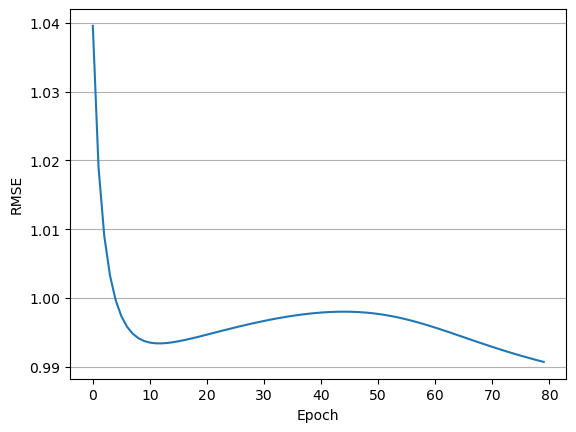

In [43]:
result_df = mf.summary 

x = result_df['epoch'].values
y = result_df['val_rmse'].values

plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(axis = 'y')
plt.show()

## ALS

In [73]:
# def als(R, P, Q, F, reg):
#     for user in range(R.shape[0]):
#         QT_Q = np.matmul(Q.T, Q)
#         li = reg * np.eye(F)
#         QT_ru = np.matmul(Q.T,R[user].toarray()[0])
#         P[user] = np.linalg.solve(QT_Q + li,QT_ru)
        
#     for item in range(R.shape[1]):
#         PT_P = np.matmul(P.T, P)
#         li = reg * np.eye(F)
#         PT_ri = np.matmul(P.T,R[:,item].toarray())
#         Q[item] = np.linalg.solve(PT_P + li,PT_ri).reshape(-1)

In [4]:
def als(R, P, Q, F ,reg):
    for user_id, R_user in enumerate(R):
        P[user_id] = np.linalg.solve(
            np.matmul(Q.T, Q) + reg * np.eye(F),
            np.matmul(Q.T, R[user_id])
        ) 
        
    for item_id, R_item in enumerate(R.T):
        Q[item_id] = np.linalg.solve(
            np.matmul(P.T, P) + reg * np.eye(F),
            np.matmul(P.T, R[:, item_id])
        ) 

In [5]:
def als_loss(sample, R, P, Q, reg):
    loss = 0
    for user, item, rating in sample: 
        loss += (rating - np.dot(P[user].T,Q[item]))**2
    for user in range(R.shape[0]):
        loss += reg * np.sum(np.square(P[user]))
    for item in range(R.shape[1]):
        loss += reg * np.sum(np.square(Q[item]))
        
    return loss / len(sample)

In [6]:
def rmse_loss(sample, P, Q):
    loss = 0 
    for user, item, rating in sample: 
        loss += pow(rating - np.dot(P[user].T,Q[item]),2)
        
    return np.sqrt(loss / len(sample))

In [20]:
class MF_with_als(object):
    def __init__(self, train_df, train_R, F, reg, epochs):
        self.train_df = train_df
        self.train_R = train_R
        self.num_users, self.num_items = train_R.shape 
        self.F = F 
        self.reg = reg 
        self.epochs = epochs 
        
        self.summary = pd.DataFrame(columns = ['epoch','test_loss'])
    
    def build_samples(self):
        self.test_samples = []
        self.users = self.train_df['Cust_ID'].values
        self.items = self.train_df['Movie_Id'].values
        self.ratings = self.train_df['Rating'].values
        
        for idx in range(len(self.train_df)):
            if (idx % 10000000) == 0:
                print(f"Loaded: {idx}th sample")
            self.test_samples.append((self.users[idx],self.items[idx],self.ratings[idx]))   
                        
    def train(self):
        self.P = np.random.normal(scale = 1/self.F, size = (self.num_users, self.F))
        self.Q = np.random.normal(scale = 1/self.F, size = (self.num_items, self.F))
            
        for epoch in range(self.epochs): 
            print(f'Start: {epoch}th epoch')
            als(self.train_R, self.P, self.Q, self.F,self.reg)
            train_loss = als_loss(self.test_samples, self.train_R, self.P, self.Q, self.reg)
            # test_loss = rmse_loss(self.test_samples, self.P, self.Q)
            
            
            print(f'Epoch: {epoch} ; val_loss = {train_loss}')
            self.summary.loc[epoch] = [epoch, train_loss]
            
    

In [21]:
als_df = sgd_df
als_df_user2idx = {user:idx for idx, user in enumerate(als_df['Cust_ID'].unique())}
als_df_item2idx = {item:idx for idx, item in enumerate(als_df['Movie_Id'].unique())}
als_df['Cust_ID'] = als_df['Cust_ID'].map(als_df_user2idx)
als_df['Movie_Id'] = als_df['Movie_Id'].map(als_df_item2idx)

/tmp/ipykernel_10185/840736911.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  als_df['Cust_ID'] = als_df['Cust_ID'].map(als_df_user2idx)
/tmp/ipykernel_10185/840736911.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  als_df['Movie_Id'] = als_df['Movie_Id'].map(als_df_item2idx)


In [216]:
splited_index = als_df.index.to_list()
np.random.shuffle(splited_index)
als_train_index = splited_index[:int(0.8*len(als_df))]
als_test_index = splited_index[int(0.8*len(als_df)):]
als_train_df = als_df.loc[als_train_index]
als_test_df = als_df.loc[als_test_index]

In [22]:
# train_R = csr_matrix(
#     (np.array(als_train_df['Rating'].values, dtype = np.int32),
#     (np.array(als_train_df['Cust_ID'].values, dtype = np.int32),np.array(als_train_df['Movie_Id'].values, dtype = np.int32))
#     ), shape=(als_df['Cust_ID'].nunique(), als_df['Movie_Id'].nunique()))

# test_R = csr_matrix(
#     (np.array(als_test_df['Rating'].values, dtype = np.int32),
#     (np.array(als_test_df['Cust_ID'].values, dtype = np.int32),np.array(als_test_df['Movie_Id'].values, dtype = np.int32))
#     ), shape=(als_df['Cust_ID'].nunique(), als_df['Movie_Id'].nunique()))

train_R = als_df.pivot_table('Rating', 'Cust_ID', 'Movie_Id').fillna(0) 
# test_R = als_test_df.pivot_table('Rating', 'Cust_ID', 'Movie_Id').fillna(0)
R = np.copy(train_R)

F = 40
reg = 8
epochs = 500 

In [226]:
# train_R = train_R.toarray()
# test_R = test_R.toarray()

In [23]:
MF_als = MF_with_als(als_df,R, 15, 2, epochs)
MF_als.build_samples()

Loaded: 0th sample


In [24]:
MF_als.train()

Start: 0th epoch
Epoch: 0 ; val_loss = 6.104721905834055
Start: 1th epoch
Epoch: 1 ; val_loss = 4.704665314180102
Start: 2th epoch
Epoch: 2 ; val_loss = 4.58960688153567
Start: 3th epoch
Epoch: 3 ; val_loss = 4.5545434067362285
Start: 4th epoch
Epoch: 4 ; val_loss = 4.535409829877034
Start: 5th epoch
Epoch: 5 ; val_loss = 4.521256138854064
Start: 6th epoch
Epoch: 6 ; val_loss = 4.510060196491721
Start: 7th epoch
Epoch: 7 ; val_loss = 4.501205943826861
Start: 8th epoch
Epoch: 8 ; val_loss = 4.494149797905374
Start: 9th epoch
Epoch: 9 ; val_loss = 4.488403264739688
Start: 10th epoch
Epoch: 10 ; val_loss = 4.483603173794562
Start: 11th epoch
Epoch: 11 ; val_loss = 4.479505796501009
Start: 12th epoch
Epoch: 12 ; val_loss = 4.475951196209764
Start: 13th epoch
Epoch: 13 ; val_loss = 4.472831426140789
Start: 14th epoch
Epoch: 14 ; val_loss = 4.470069826050181
Start: 15th epoch
Epoch: 15 ; val_loss = 4.467609035850065
Start: 16th epoch
Epoch: 16 ; val_loss = 4.465404284391892
Start: 17th epoch

In [25]:
MF_als.summary

,epoch,test_loss
0,0.0,6.104722
1,1.0,4.704665
2,2.0,4.589607
3,3.0,4.554543
4,4.0,4.535410
...,...,...
495,495.0,4.459385
496,496.0,4.459385
497,497.0,4.459385
498,498.0,4.459385


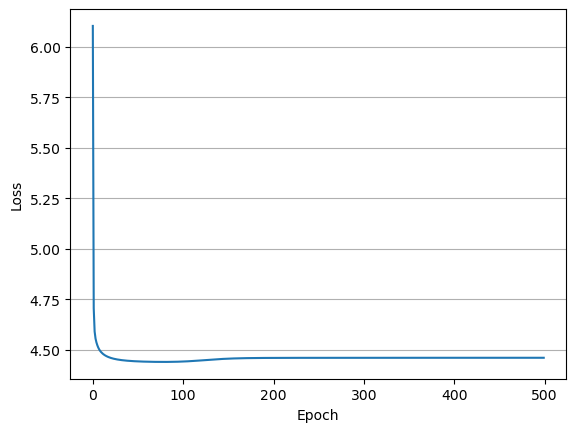

In [27]:
result_df = MF_als.summary 

x = result_df['epoch'].values
y = result_df['test_loss'].values

plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(axis = 'y')
plt.show()

## Pytorch Implementation

### Training Setting

In [3]:
class Netflix(Dataset):
    def __init__(self, df):
        self.df = df
        self.users = self.df['Cust_ID'].values
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        user = self.users[index]
        item = self.items[index]
        rating = self.ratings[index]
        
        return user, item, rating

In [4]:
df['Cust_ID'].nunique()

480189

In [5]:
df['Movie_Id'].nunique()

17770

In [4]:
sample_df = df.loc[(df['Cust_ID'] < 2500) & (df['Movie_Id'] < 92)]
sample_df

,Cust_ID,Movie_Id,Rating,Timestamp
0,0,0,3.0,2005-09-06
1,1,0,5.0,2005-05-13
2,2,0,4.0,2005-10-19
3,3,0,4.0,2005-12-26
4,4,0,3.0,2004-05-03
...,...,...,...,...
338928,327,91,1.0,2004-08-12
338930,650,91,2.0,2005-11-16
338958,436,91,5.0,2005-10-22
338960,442,91,1.0,2004-11-19


In [5]:
# sample_df = sample_df[['Cust_ID','Movie_Id','Rating']]
sample_df_user2idx = {user:idx for idx, user in enumerate(sample_df['Cust_ID'].unique())} 
sample_df_item2idx = {item:idx for idx, item in enumerate(sample_df['Movie_Id'].unique())}
sample_df['Cust_ID'] = sample_df['Cust_ID'].map(sample_df_user2idx)
sample_df['Movie_Id'] = sample_df['Movie_Id'].map(sample_df_item2idx)
sample_df['Timestamp'] = pd.to_datetime(sample_df['Timestamp'])
sample_df

/tmp/ipykernel_25135/2844881322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['Cust_ID'] = sample_df['Cust_ID'].map(sample_df_user2idx)
/tmp/ipykernel_25135/2844881322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['Movie_Id'] = sample_df['Movie_Id'].map(sample_df_item2idx)
/tmp/ipykernel_25135/2844881322.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,Cust_ID,Movie_Id,Rating,Timestamp
0,0,0,3.0,2005-09-06
1,1,0,5.0,2005-05-13
2,2,0,4.0,2005-10-19
3,3,0,4.0,2005-12-26
4,4,0,3.0,2004-05-03
...,...,...,...,...
338928,327,91,1.0,2004-08-12
338930,650,91,2.0,2005-11-16
338958,436,91,5.0,2005-10-22
338960,442,91,1.0,2004-11-19


In [6]:
bins = pd.date_range(start = '1999-12-01', end = '2005-12-31', freq = 'M')
sample_df.loc[:,'bins'] = pd.cut(sample_df['Timestamp'], bins=bins, labels=False)

/tmp/ipykernel_25135/3691379335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.loc[:,'bins'] = pd.cut(sample_df['Timestamp'], bins=bins, labels=False)


In [7]:
sample_df = sample_df[['Cust_ID','Movie_Id','Rating','bins']]

In [8]:
train_df, test_df = train_test_split(sample_df, test_size = 0.2, random_state = 42)

In [9]:
train_dataset = Netflix(train_df)
test_dataset = Netflix(test_df)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def train(model, train_loader, criterion ,optimizer):
    model.train() 
    total_loss = 0 
    for user, item, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        pred = model(user, item)
        loss = criterion(pred, rating)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for user, item, rating in test_loader:
            try:
                user = user.to(device)
                item = item.to(device)
                rating = rating.to(device)

                pred = model(user, item)
                loss = criterion(pred, rating)

                total_loss += loss.item()
            except:
                pass
    
    return total_loss / len(test_loader)

In [12]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

### Models

In [13]:
class BasicFactorizaionModel(nn.Module):
    def __init__(self, num_users, num_items, F):
        
        super(BasicFactorizaionModel, self).__init__()
        self.P = nn.Embedding(num_users, F)
        self.Q = nn.Embedding(num_items, F)
        
        self.P.weight.data.normal_(0,1./F)
        self.Q.weight.data.normal_(0,1./F)
    
    def forward(self, user, item):
        P_u = self.P(user)
        Q_i = self.Q(item)
        
        rui = torch.sum(P_u * Q_i, dim = 1)
        
        return rui


In [14]:
class AddingBiases(BasicFactorizaionModel):
    def __init__(self, num_users, num_items, F, mu):
        
        super(AddingBiases, self).__init__(num_users, num_items, F)
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)
        
        self.user_biases.weight.data.normal_(0,1)
        self.item_biases.weight.data.normal_(0,1)
        
        self.mu = mu
        
    def forward(self, user, item):
        P_u = self.P(user)
        Q_i = self.Q(item)
        
        bu = self.user_biases(user) 
        bi = self.item_biases(item)
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(P_u * Q_i, dim = 1)
        
        return rui 

In [15]:
class AdditionalInputSources(AddingBiases):
    def __init__(self, num_users, num_items, F, mu, implicit_data):
        super(AdditionalInputSources, self).__init__(num_users, num_items, F, mu)
        self.implicit_data = implicit_data
        
        self.implicit_factors = nn.Embedding(num_items, F)
        self.implicit_factors.weight.data.normal_(0,1./F)
        
    def forward(self, user, item):
        P_u = self.P(user)
        Q_i = self.Q(item)
        
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        sum_of_xi = torch.sum(self.implicit_factors(self.implicit_data[int(user)]),dim = 0)
        norm = len(self.implicit_data[user]) ** -0.5
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(Q_i * (P_u + (norm * sum_of_xi)), dim = 1)
        
        return rui
        

In [16]:
class TemporalDynamics(AddingBiases):
    def __init__(self, num_users, num_items, F, mu, T):
        super(TemporalDynamics, self).__init__(num_users, num_items, F, mu)
        
        self.temporal_user_biases = nn.Parameter(torch.normal(0,1,size=(num_users, T)))
        self.temporal_item_biases = nn.Parameter(torch.normal(0,1,size=(num_items, T)))
        self.temporal_user_factors = nn.Parameter(torch.normal(0,1/F,size=(num_users, T, F)))
        
        
    def forward(self, user, item, time_bin):
        Q_i = self.Q(item)
        P_ut = self.temporal_user_factors[user,time_bin,:]
        
        but = self.temporal_user_biases[user,time_bin]
        bit = self.temporal_item_biases[item,time_bin]
    

        rui = self.mu + torch.squeeze(but) + torch.squeeze(bit) + torch.sum(Q_i * P_ut, dim = 1)
        
        return rui

## 다른 논문

In [17]:
class BaselineEstimates(nn.Module):
    def __init__(self, num_users, num_items, mu):
        super(BaselineEstimates, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.mu = mu
        
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)
        
        self.user_biases.weight.data.normal_(0,1)
        self.item_biases.weight.data.normal_(0,1)
    
    def forward(self, user, item):
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi)
        
        return rui

In [49]:
class NeighborhoodModel(BaselineEstimates):
    def __init__(self, num_users, num_items, mu, implicit_data, R, S, k):
        super(NeighborhoodModel, self).__init__(num_users, num_items, mu)
        self.R = R 
        self.S = S
        self.k = k 
        self.implicit_data = implicit_data
        self.item_weights = nn.Parameter(torch.normal(size=(num_items,num_items)))
        self.implicit_offset = nn.Parameter(torch.normal(size=(num_items,num_items)))
        
        self.similar_k = []
        
        self.item_weights.weight.data.normal_(0,1)
        self.implicit_offset.weight.data.normal_(0,1)
        
    def get_top_n_indices(self, list, n):
        sorted_indices = sorted(range(len(list)), key=lambda i: list[i], reverse=True)
        top_n_indices = sorted_indices[:n]
        
        return top_n_indices

    def get_top_k(self):
        for item in range(self.num_items):
            self.similar_k.append(self.get_top_n_indices(self.S[item], self.k))
            
    def forward(self, user, item):
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        bui = self.mu + torch.squeeze(bu) + torch.squeeze(bi)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        num_k = 0
        
        self.used_items = self.implicit_data[user]
        
        for implicit in self.implicit_data[user]:
            if implicit in self.similar_k[item]:
                num_k += 1
                
                with torch.no_grad():
                    bj = self.item_biases(implicit)
                    buj = self.mu + torch.squeeze(bu) + torch.squeeze(bj)
                sum_of_item_weights += (self.R[user][implicit]-buj) * self.item_weights[item][implicit]
                sum_of_implicit_offset += self.implicit_offset[item][implicit]        
            
        norm = num_k ** -0.5

        rui = bui + norm * sum_of_item_weights + norm * sum_of_implicit_offset
        
        return rui

In [ ]:
class AsymmetricSVD(BaselineEstimates):
    def __init__(self, num_users, num_items, mu, F, implicit_data,R):
        super(AsymmetricSVD, self).__init__(num_users, num_items, mu)
        self.R = R 
        self.implicit_data = implicit_data
        self.Q = nn.Embedding(num_items, F)
        self.X = nn.Embedding(num_items, F)
        self.Y = nn.Embedding(num_items, F)
        
        self.Q.weight.data.normal_(0, 1/F)
        self.X.weight.data.normal_(0, 1/F)
        self.Y.weight.data.normal_(0, 1/F)
        
    def forward(self, user, item):
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        Q_i = self.Q(item)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        
        for implicit in self.implicit_data[user]:
            with torch.no_grad():
                bj = self.item_biases(implicit)
                buj = self.mu + torch.squeeze(bu) + torch.squeeze(bj)
            sum_of_item_weights += (self.R[user][implicit] - buj) * self.X(implicit)
            sum_of_implicit_offset += self.Y(implicit)
            
        norm = len(self.implicit_data[user]) ** -0.5        
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(Q_i * (norm * (sum_of_item_weights + sum_of_implicit_offset)), dim = 1)
        
        return rui

In [ ]:
class SVDPlusPlus(BaselineEstimates):
    def __init__(self, num_users, num_items, mu, F, implicit_data)
        super(SVDPlusPlus, self).__init__(num_users, num_items, mu)
        
        self.implicit_data = implicit_data
        self.user_embedding = nn.Embedding(num_users, F)
        self.item_embedding = nn.Embedding(num_items, F)
        
        self.Y = nn.Embedding(num_items, F)
        
        self.user_embedding.weight.data.normal_(0,1/F)
        self.item_embedding.weight.data.normal_(0,1/F)
        self.Y.weight.data.normal_(0,1/F)
        
    def forward(self, user, item):
        
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        P_u = self.user_embedding(user)
        Q_i = self.item_embedding(item)
        
        sum_of_implicit_offset = 0
        for implicit in self.implicit_data[user]:
            sum_of_implicit_offset += self.Y(implicit)
        
        norm = len(self.implicit_data[user]) ** -0.5
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(P_u * (Q_i + norm * sum_of_implicit_offset), dim = 1)
        
        return rui

In [ ]:
class IntergratedModel(nn.Module):
    def __init__(self, num_users, num_items, mu, F, implicit_data, R, S, k):
        super(IntergratedModel, self).__init__()
        self.neighbor = NeighborhoodModel(num_users, num_items, mu, implicit_data, R, S, k)
        self.SVD = SVDPlusPlus(num_users, num_items, mu, F, implicit_data)
        
    def forward(self, user, item):
        rui = self.neighbor(user, item) + self.SVD(user, item)
        
        return rui

## 개정 

In [18]:
class BaselineEstimates(nn.Module):
    def __init__(self, num_users, num_items, mu):
        super(BaselineEstimates, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.mu = mu
        
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)
        
        self.user_biases.weight.data.normal_(0,1)
        self.item_biases.weight.data.normal_(0,1)
    
    def forward(self, user, item):
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi)
        
        return rui

In [245]:
class NeighborhoodModel(nn.Module):
    def __init__(self, num_users, num_items, mu, implicit_data, R, S, k):
        super(NeighborhoodModel, self).__init__()
        self.Base = BaselineEstimates(num_users, num_items, mu)
        self.R = R 
        self.S = S
        self.k = k 
        self.implicit_data = implicit_data
        self.item_weights = nn.Parameter(torch.normal(size=(num_items,num_items)))
        self.implicit_offset = nn.Parameter(torch.normal(size=(num_items,num_items)))
        self.mu = mu
        
        self.similar_k = []
        
        self.item_weights.weight.data.normal_(0,1)
        self.implicit_offset.weight.data.normal_(0,1)
        
    def get_top_n_indices(self, list, n):
        sorted_indices = sorted(range(len(list)), key=lambda i: list[i], reverse=True)
        top_n_indices = sorted_indices[:n]
        
        return top_n_indices

    def get_top_k(self):
        for item in range(self.num_items):
            self.similar_k.append(self.get_top_n_indices(self.S[item], self.k))
            
    def forward(self, user, item):
        bui = self.Base(user, item)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        num_k = 0
        
        self.used_items = self.implicit_data[user]
        
        for implicit in self.implicit_data[user]:
            if implicit in self.similar_k[item]:
                num_k += 1
                
                with torch.no_grad():
                    bj = self.Base.item_biases(implicit)
                    buj = self.mu + torch.squeeze(self.Base.user_biases(user)) + torch.squeeze(bj)
                    
                sum_of_item_weights += (self.R[user][implicit]-buj) * self.item_weights[item][implicit]
                sum_of_implicit_offset += self.implicit_offset[item][implicit]        
            
        norm = num_k ** -0.5

        rui = bui + norm * sum_of_item_weights + norm * sum_of_implicit_offset
        
        return rui

In [40]:
class AsymmetricSVD(nn.Module):
    def __init__(self, num_users, num_items, mu, F, implicit_data,R):
        super(AsymmetricSVD, self).__init__()
        self.Base = BaselineEstimates(num_users, num_items, mu)
        self.R = R 
        self.implicit_data = implicit_data
        self.Q = nn.Embedding(num_items, F)
        self.X = nn.Embedding(num_items, F)
        self.Y = nn.Embedding(num_items, F)
        
        self.Q.weight.data.normal_(0, 1/F)
        self.X.weight.data.normal_(0, 1/F)
        self.Y.weight.data.normal_(0, 1/F)
        
    def forward(self, user, item):
        bui = self.Base(user, item)
        Q_i = self.Q(item)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        
        for implicit in self.implicit_data[user]:
            with torch.no_grad():
                bj = self.item_biases(implicit)
                buj = self.mu + torch.squeeze(bu) + torch.squeeze(bj)
            sum_of_item_weights += (self.R[user][implicit] - buj) * self.X(implicit)
            sum_of_implicit_offset += self.Y(implicit)
            
        norm = len(self.implicit_data[user]) ** -0.5        
        
        rui = bui + torch.sum(Q_i * (norm * (sum_of_item_weights + sum_of_implicit_offset)), dim = 1)
        
        return rui

In [41]:
class SVDPlusPlus(nn.Module):
    def __init__(self, num_users, num_items, mu, F, implicit_data, is_layer=False):
        super(SVDPlusPlus, self).__init__()
        self.is_layer = is_layer
        self.Base = BaselineEstimates(num_users, num_items, mu)
        
        self.implicit_data = implicit_data
        self.user_embedding = nn.Embedding(num_users, F)
        self.item_embedding = nn.Embedding(num_items, F)
        
        self.Y = nn.Embedding(num_items, F)
        
        self.user_embedding.weight.data.normal_(0,1/F)
        self.item_embedding.weight.data.normal_(0,1/F)
        self.Y.weight.data.normal_(0,1/F)
        
    def forward(self, user, item):
        bui = self.Base(user, item)
        
        P_u = self.user_embedding(user)
        Q_i = self.item_embedding(item)
        
        sum_of_implicit_offset = 0
        for implicit in self.implicit_data[user]:
            sum_of_implicit_offset += self.Y(implicit)
        
        norm = len(self.implicit_data[user]) ** -0.5
        
        if self.is_layer:
            rui = torch.sum(P_u * (Q_i + norm * sum_of_implicit_offset), dim = 1)
        else:
            rui = bui + torch.sum(P_u * (Q_i + norm * sum_of_implicit_offset), dim = 1)
        
        return rui

In [42]:
class IntergratedModel(nn.Module):
    def __init__(self, num_users, num_items, mu, F, implicit_data, R, S, k):
        super(IntergratedModel, self).__init__()
        self.neighbor = NeighborhoodModel(num_users, num_items, mu, implicit_data, R, S, k)
        self.SVD = SVDPlusPlus(num_users, num_items, mu, F, implicit_data, is_layer=True)
        
    def forward(self, user, item):
        rui = self.neighbor(user, item) + self.SVD(user, item)
        
        return rui

## Test

In [99]:
mu = train_df.Rating.mean() 
implicit_data = train_df.groupby('Cust_ID')['Movie_Id'].apply(list)

tmp_implicit_data = [[] for _ in range(1000)]  
for idx, i in enumerate(implicit_data):
    tmp_implicit_data[implicit_data.index[idx]].append(torch.LongTensor(i).to(device))
    
model = AdditionalInputSources(len(sample_df_user2idx), len(sample_df_item2idx), 20, mu, tmp_implicit_data)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

best_metric = 1 
summary = pd.DataFrame({'epoch':[], 'train_loss':[], 'val_loss':[]})

for epoch in range(0, 31):
    print(f'epoch: {epoch} start')
    train_loss = train(model, train_dataloader, RMSELoss, optimizer)
    val_loss = evaluate(model, test_dataloader, RMSELoss)
    
    print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}')
    summary.loc[epoch] = [epoch, train_loss, val_loss]
    

epoch: 0 start
epoch: 0, train_loss: 4.785584051672856e+33, val_loss: 8.660470352966813e+35
epoch: 1 start
epoch: 1, train_loss: nan, val_loss: nan
epoch: 2 start
epoch: 2, train_loss: nan, val_loss: nan
epoch: 3 start
epoch: 3, train_loss: nan, val_loss: nan
epoch: 4 start


In [54]:
df.Timestamp = pd.to_datetime(df.Timestamp, format = '%Y-%m')

In [61]:
grouped = df.groupby('Timestamp')['Rating'].mean()

In [62]:
grouped

Timestamp
1999-11-11    3.428571
1999-12-06    3.333333
1999-12-08    3.655172
1999-12-09    3.487500
1999-12-10    3.666667
                ...   
2005-12-27    3.636133
2005-12-28    3.658005
2005-12-29    3.686704
2005-12-30    3.674725
2005-12-31    3.704992
Name: Rating, Length: 2182, dtype: float64

In [63]:
window = 30  # 이동평균 윈도우 크기
grouped = grouped.rolling(window).mean()

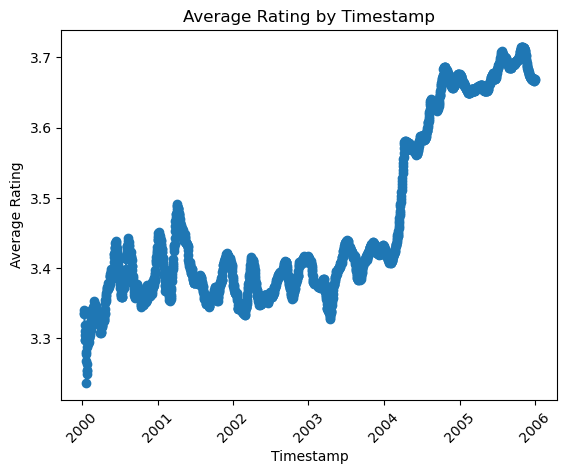

In [64]:
plt.plot(grouped.index, grouped.values, marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Average Rating')
plt.title('Average Rating by Timestamp')
plt.xticks(rotation=45)
plt.show()

## Neighbor Test

In [24]:
R = csr_matrix(
    (np.array(train_df['Rating'].values, dtype = np.int32),
    (np.array(train_df['Cust_ID'].values, dtype = np.int32),np.array(train_df['Movie_Id'].values, dtype = np.int32))
    ), shape = (len(sample_df_user2idx), len(sample_df_item2idx)))

In [29]:
class NeighborhoodModel(nn.Module):
    def __init__(self, R,mu, k):
        super(NeighborhoodModel, self).__init__()
        self.R = R 
        self.k = k
        self.num_users, self.num_items = R.shape
        self.Base = BaselineEstimates(self.num_users, self.num_items, mu)
        self.item_weights = nn.Parameter(torch.normal(0,1,size=(self.num_items,self.num_items)))
        self.implicit_offset = nn.Parameter(torch.normal(0,1,size=(self.num_items,self.num_items)))
        self.mu = mu
        self.S = cosine_similarity(R.T)
                
        # self.item_weights.weight.data.normal_(0,1)
        # self.implicit_offset.weight.data.normal_(0,1)
        
    def get_top_n_indices(self, list, n):
        sorted_indices = sorted(range(len(list)), key=lambda i: list[i], reverse=True)
        top_n_indices = sorted_indices[:n]
        
        return top_n_indices

    def get_top_k(self):
        self.similar_k = {}
        for item in range(self.num_items):
            self.similar_k[item] = self.get_top_n_indices(self.S[item], self.k)
            
    def get_implicit(self):
        self.implicit_data = {} 
        users, items = R.toarray().nonzero()
        for user, item in zip(users, items):
            if user not in self.implicit_data:
                self.implicit_data[user] = []
            self.implicit_data[user].append(item)
  
    def forward(self, user, item):
        bui = self.Base(user, item)
        user_idx = int(user)
        item_idx = int(item)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        num_k = 0
        
        self.used_items = self.implicit_data[user_idx]
        
        for implicit in self.implicit_data[user_idx]:
            if implicit in self.similar_k[item_idx]:
                implicit_tensor = torch.LongTensor([implicit]).to(device)
                num_k += 1
                
                with torch.no_grad():
                    buj = self.Base(user, implicit_tensor)
                    
                sum_of_item_weights += (int(self.R[user,implicit].data)-buj) * self.item_weights[item][0][implicit]
                sum_of_implicit_offset += self.implicit_offset[item][0][implicit]        
            
        norm = num_k ** -0.5

        rui = bui + norm * sum_of_item_weights + norm * sum_of_implicit_offset
        
        return rui

In [31]:
mu = train_df.Rating.mean() 
model = NeighborhoodModel(R, mu, 5)


In [260]:
model.get_implicit()
model.get_top_k()

In [261]:
device = torch.device('cpu')

In [256]:
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

best_metric = 1 
summary = pd.DataFrame({'epoch':[], 'train_loss':[], 'val_loss':[]})

for epoch in range(0, 31):
    print(f'epoch: {epoch} start')
    train_loss = train(model, train_dataloader, RMSELoss, optimizer)
    val_loss = evaluate(model, test_dataloader, RMSELoss)
    
    print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}')
    summary.loc[epoch] = [epoch, train_loss, val_loss]
    

epoch: 0 start
epoch: 0, train_loss: 0.622453521526758, val_loss: 0.8263899317684921
epoch: 1 start
epoch: 1, train_loss: 0.39978697247888034, val_loss: 0.7565786944904466
epoch: 2 start
epoch: 2, train_loss: 0.3776391831088108, val_loss: 0.7324660293769097
epoch: 3 start
epoch: 3, train_loss: 0.3670304416771244, val_loss: 0.7923912673875533
epoch: 4 start
epoch: 4, train_loss: 0.3551513009294392, val_loss: 0.7553155518184905
epoch: 5 start
epoch: 5, train_loss: 0.34936424383718134, val_loss: 0.791883708626822
epoch: 6 start
epoch: 6, train_loss: 0.35093378408229514, val_loss: 0.8215925696046428
epoch: 7 start
epoch: 7, train_loss: 0.35111757789315634, val_loss: 0.7969914830703029
epoch: 8 start
epoch: 8, train_loss: 0.3525471170661822, val_loss: 0.7919800053721013
epoch: 9 start
epoch: 9, train_loss: 0.3528641533606658, val_loss: 0.8151825267100347
epoch: 10 start
epoch: 10, train_loss: 0.3541123909628967, val_loss: 0.7996981177048542
epoch: 11 start
epoch: 11, train_loss: 0.355602698

## AsymmetricSVD Test 

In [27]:
class AsymmetricSVD(nn.Module):
    def __init__(self, R, mu, F):
        super(AsymmetricSVD, self).__init__()
        self.num_users, self.num_items = R.shape
        self.Base = BaselineEstimates(self.num_users, self.num_items, mu)
        self.R = R 
        self.Q = nn.Embedding(self.num_items, F)
        self.X = nn.Embedding(self.num_items, F)
        self.Y = nn.Embedding(self.num_items, F)
        
        self.Q.weight.data.normal_(0, 1/F)
        self.X.weight.data.normal_(0, 1/F)
        self.Y.weight.data.normal_(0, 1/F)
        
    def get_implicit(self):
        self.implicit_data = {} 
        users, items = R.toarray().nonzero()
        for user, item in zip(users, items):
            if user not in self.implicit_data:
                self.implicit_data[user] = []
            self.implicit_data[user].append(item)
        
    def forward(self, user, item):
        user_idx = int(user)
        
        bui = self.Base(user, item)
        Q_i = self.Q(item)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        
        for implicit in self.implicit_data[user_idx]:
            implicit_tensor = torch.LongTensor([implicit]).to(device)
            with torch.no_grad():
                buj = self.Base(user, implicit_tensor)
                
            sum_of_item_weights += (int(self.R[user,implicit].data) - buj) * self.X(implicit_tensor)
            sum_of_implicit_offset += self.Y(implicit_tensor)
            
        norm = len(self.implicit_data[user_idx]) ** -0.5        
        
        rui = bui + torch.sum(Q_i * (norm * (sum_of_item_weights + sum_of_implicit_offset)), dim = 1)
        
        return rui

In [273]:
mu = train_df.Rating.mean() 
model = AsymmetricSVD(R,mu, 20)
model.get_implicit()
device = torch.device('cpu')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

best_metric = 1 
summary = pd.DataFrame({'epoch':[], 'train_loss':[], 'val_loss':[]})

for epoch in range(0, 31):
    print(f'epoch: {epoch} start')
    train_loss = train(model, train_dataloader, RMSELoss, optimizer)
    val_loss = evaluate(model, test_dataloader, RMSELoss)
    
    print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}')
    summary.loc[epoch] = [epoch, train_loss, val_loss]
    

epoch: 0 start
epoch: 0, train_loss: 0.6986598813505259, val_loss: 0.9947714358568192
epoch: 1 start
epoch: 1, train_loss: 0.5851209419304672, val_loss: 0.9911296897199287
epoch: 2 start
epoch: 2, train_loss: 0.5654666379987112, val_loss: 0.9564874087529758
epoch: 3 start
epoch: 3, train_loss: 0.54976838750325, val_loss: 0.927793711692229
epoch: 4 start
epoch: 4, train_loss: 0.5427328251338596, val_loss: 0.9848491631340182
epoch: 5 start
epoch: 5, train_loss: 0.5348831640977548, val_loss: 1.0254358974261664
epoch: 6 start


## SVD++ Test

In [25]:
class SVDPlusPlus(nn.Module):
    def __init__(self, R, mu, F, is_layer=False):
        super(SVDPlusPlus, self).__init__()
        self.is_layer = is_layer
        self.R = R 
        self.num_users, self.num_items = R.shape
        self.Base = BaselineEstimates(self.num_users, self.num_items, mu)
        
        self.user_embedding = nn.Embedding(self.num_users, F)
        self.item_embedding = nn.Embedding(self.num_items, F)
        
        self.Y = nn.Embedding(self.num_items, F)
        
        self.user_embedding.weight.data.normal_(0,1/F)
        self.item_embedding.weight.data.normal_(0,1/F)
        self.Y.weight.data.normal_(0,1/F)
        
    def get_implicit(self):
        self.implicit_data = {} 
        users, items = R.toarray().nonzero()
        for user, item in zip(users, items):
            if user not in self.implicit_data:
                self.implicit_data[user] = []
            self.implicit_data[user].append(item)
        
    def forward(self, user, item):
        user_idx = int(user)
        
        bui = self.Base(user, item)
        
        P_u = self.user_embedding(user)
        Q_i = self.item_embedding(item)
        
        sum_of_implicit_offset = 0
        for implicit in self.implicit_data[user_idx]:
            implicit_tensor = torch.LongTensor([implicit]).to(device)
            sum_of_implicit_offset += self.Y(implicit_tensor)
        
        norm = len(self.implicit_data[user_idx]) ** -0.5
        
        if self.is_layer:
            rui = torch.sum(P_u * (Q_i + norm * sum_of_implicit_offset), dim = 1)
        else:
            rui = bui + torch.sum(P_u * (Q_i + norm * sum_of_implicit_offset), dim = 1)
        
        return rui

In [ ]:
mu = train_df.Rating.mean() 
model = SVDPlusPlus(R, mu, 20)
model.get_implicit()
device = torch.device('cpu')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

best_metric = 1 
summary = pd.DataFrame({'epoch':[], 'train_loss':[], 'val_loss':[]})

for epoch in range(0, 31):
    print(f'epoch: {epoch} start')
    train_loss = train(model, train_dataloader, RMSELoss, optimizer)
    val_loss = evaluate(model, test_dataloader, RMSELoss)
    
    print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}')
    summary.loc[epoch] = [epoch, train_loss, val_loss]
    

##  Intergrated Test

In [34]:
class IntergratedModel(nn.Module):
    def __init__(self, R, mu, F, k):
        super(IntergratedModel, self).__init__()
        self.neighbor = NeighborhoodModel(R,mu,k)
        self.SVD = SVDPlusPlus(R,mu,F, is_layer=True)
        
    def model_init(self):
        self.neighbor.get_implicit()
        self.neighbor.get_top_k()
        self.SVD.get_implicit()
        
    def forward(self, user, item):
        rui = self.neighbor(user, item) + self.SVD(user, item)
        
        return rui

In [35]:
mu = train_df.Rating.mean() 
model = IntergratedModel(R, mu, 20, 5)
model.model_init()
device = torch.device('cpu')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

best_metric = 1 
summary = pd.DataFrame({'epoch':[], 'train_loss':[], 'val_loss':[]})

for epoch in range(0, 31):
    print(f'epoch: {epoch} start')
    train_loss = train(model, train_dataloader, RMSELoss, optimizer)
    val_loss = evaluate(model, test_dataloader, RMSELoss)
    
    print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}')
    summary.loc[epoch] = [epoch, train_loss, val_loss]
    

epoch: 0 start
epoch: 0, train_loss: 0.6343768035409695, val_loss: 0.7460026293191658
epoch: 1 start
epoch: 1, train_loss: 0.39162416618010226, val_loss: 0.7726222559075435
epoch: 2 start
epoch: 2, train_loss: 0.35223923379213484, val_loss: 0.7968696838113414
epoch: 3 start
epoch: 3, train_loss: 0.3383389142825808, val_loss: 0.7939018138300902
epoch: 4 start
epoch: 4, train_loss: 0.3280554994484942, val_loss: 0.8061952504062426
epoch: 5 start
epoch: 5, train_loss: 0.3217552751894627, val_loss: 0.7928626581433864
epoch: 6 start
epoch: 6, train_loss: 0.3202105530520304, val_loss: 0.7533481101048416
epoch: 7 start
epoch: 7, train_loss: 0.3197014715168781, val_loss: 0.8231635082451596
epoch: 8 start
epoch: 8, train_loss: 0.32314364579570887, val_loss: 0.8086306941455575
epoch: 9 start
epoch: 9, train_loss: 0.3223049497493073, val_loss: 0.8103082744537919
epoch: 10 start
epoch: 10, train_loss: 0.32487125970664643, val_loss: 0.7900588867059346
epoch: 11 start
epoch: 11, train_loss: 0.3255467

## Temporal Test

In [26]:
class Temporal_Netflix(Dataset):
    def __init__(self, df):
        self.df = df
        self.users = self.df['Cust_ID'].values
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        self.time = self.df['bins'].values
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        user = self.users[index]
        item = self.items[index]
        time = self.time[index]

        rating = self.ratings[index]
        
        return user, item,time, rating
    


In [27]:
train_df, test_df = train_test_split(sample_df, test_size = 0.2, random_state = 42)
train_dataset = Temporal_Netflix(train_df)
test_dataset = Temporal_Netflix(test_df)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

def temporal_train(model, train_loader):
    model.train() 
    total_loss = 0 
    for user, item, time,rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        time = time.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        pred = model(user, item,time)
        loss = criterion(pred, rating)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    total_loss = total_loss / len(train_loader)
    
    return total_loss

def temporal_evaluate(model, test_loader):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for user, item, time,rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            time = time.to(device)
            rating = rating.to(device)

            pred = model(user, item,time)
            loss = criterion(pred, rating)

            total_loss += loss.item()
    
    return total_loss / len(test_loader)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
mu = train_df.Rating.mean()
model = TemporalDynamics(len(sample_df_user2idx), len(sample_df_item2idx), 20, mu, 72)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = RMSELoss

best_metric = 1 
summary = pd.DataFrame({'epoch':[], 'train_loss':[], 'val_loss':[]})

for epoch in range(0, 31):
    print(f'epoch: {epoch} start')
    train_loss = temporal_train(model, train_dataloader)
    val_loss = temporal_evaluate(model, test_dataloader)
    
    print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}')
    summary.loc[epoch] = [epoch, train_loss, val_loss]